# Code breakdown

## Load image
All images used are from proc directory (real-time flat-field corrected images using PCA, c/o Sarlota)

## High-Pass adaptive filter
Filtering of the image is done using
   
   a. Gaussian convolution (5x5 kernel, std. dev = 5) of the proc image
   b. Subtracting 'a' from original proc image to produce difference_image
   c. difference_image is used for ROI and Optical Flow

## ROI identification
    a. Identify coordinates

## Horn-Schunck Method Optical Flow algorithm 
Please see the powerpoint for reference. 

    a. Precompute the image and temporal gradient
        Calculations of image gradients are done using Sobel operator with kernel size = 3. 
        This is implemented using OpenCV. 
    b. Initializing flow field and Iteration
        Smoothing operator alpha is defined; number of iteration is defined
        Minimum alpha makes the algorithm more sensitive to noise and subtle changes. Increasing alpha smoothens out the flow velocity.
        I used alpha = 2, iteration = 100
    c. Averaging kernel for iteration
        3x3 kernel based on discrete approx. of Laplacian smoothing filter
    d. Conversion of velocity
        Conversion is based on the detector parameters (pixel size, frame rate) using Shimadzu HPV-X2 (1.125 MHz)
  
## Visualization
    a. Quiver plot 
    b. Step size
        Minimum step size of 1 makes the quiver plotting very dense. Increasing the step size makes the quiver plot more sparse. 
        I used step size = 3
    c. Scale factor is used to increase visibility of quiver plot
    d. Masking out
        I used masked out to display only quiver plots related to the moving objects and only show the results based on the threshold.
        For threshold, I use either the mean velocity magnitude or fixed value (e.g. >= 0.2)
        

## Single Result

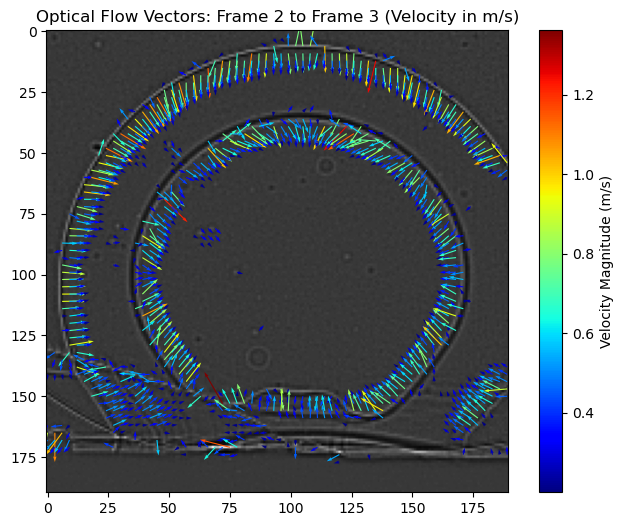

In [14]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
proc_directory = r'E:\EuXFEL_5157_Data_Part2\proc'
run_id = 121  # Change the run number here
file_name = f'CORR-R{run_id:04d}-HPVX01-S00000.h5'

# Define the specific train and frame range to analyze
train_id = 3
frame_2 = 2  # Frame 2
frame_3 = 3  # Frame 5

# Construct the proc_directory dynamically
proc_directory = os.path.join(proc_directory, f'r{run_id:04d}')
full_path = os.path.join(proc_directory, file_name)

def get_frame(file_path, train_id, frame_number):
    """Load a specific frame from the HDF5 file."""
    with h5py.File(file_path, "r") as f:
        return f['INSTRUMENT']['SPB_EHD_MIC']['CORR']['HPVX2_1:output']['data']['image']['pixels'][train_id, frame_number]

def apply_roi(image, roi):
    """Apply Region of Interest (ROI) to the frame."""
    x_start, y_start, x_end, y_end = roi
    return image[y_start:y_end, x_start:x_end]

# Load the frames 2 and 5
frame_2_image = get_frame(full_path, train_id, frame_2)
frame_3_image = get_frame(full_path, train_id, frame_3)

# Apply Gaussian convolution filter to frame 2 and frame 5
filtered_frame_2 = cv2.GaussianBlur(frame_2_image, (5, 5), 5)
filtered_frame_3 = cv2.GaussianBlur(frame_3_image, (5, 5), 5)

# Subtract the Gaussian filtered image from the original image
difference_image_2 = cv2.subtract(frame_2_image, filtered_frame_2)
difference_image_3 = cv2.subtract(frame_3_image, filtered_frame_3)

# Now proceed with ROI and optical flow analysis
# Define ROI coordinates (x_start, y_start, x_end, y_end)
roi = (210, 35, 400, 225)  # Example ROI coordinates

# Apply ROI to both difference images
image_2_roi = apply_roi(difference_image_2, roi)
image_3_roi = apply_roi(difference_image_3, roi)

def compute_image_gradients(image1, image2):
    """Compute gradients of image intensity in x, y, and t directions."""
    Ix = cv2.Sobel(image1, cv2.CV_64F, 1, 0, ksize=3)  # Gradient along x
    Iy = cv2.Sobel(image1, cv2.CV_64F, 0, 1, ksize=3)  # Gradient along y
    It = image2 - image1  # Temporal gradient (change over time)
    return Ix, Iy, It

def optical_flow(Ix, Iy, It, alpha=2, num_iter=100):
    """Compute optical flow using the Horn-Schunck method."""
    u = np.zeros_like(Ix)
    v = np.zeros_like(Iy)
    
    # Averaging kernel
    kernel = np.array([[1/12, 1/6, 1/12], [1/6, 0, 1/6], [1/12, 1/6, 1/12]])
    
    for _ in range(num_iter):
        # Compute local averages of u and v
        u_avg = cv2.filter2D(u, -1, kernel)
        v_avg = cv2.filter2D(v, -1, kernel)
        
        # Update flow estimates
        P = (Ix * u_avg + Iy * v_avg + It) / (alpha**2 + Ix**2 + Iy**2 + 1e-5)  # Add a small constant to avoid division by zero
        u = u_avg - Ix * P
        v = v_avg - Iy * P
    
    return u, v

# Convert pixel velocity to meters/second
def convert_to_velocity(u, v, fps, px_size):
    """Convert pixel displacement to velocity in meters/second."""
    # Time between frames (in seconds)
    delta_t = 1 / fps
    # Convert displacement in pixels to displacement in meters
    u_meters_per_sec = (u * px_size) / delta_t
    v_meters_per_sec = (v * px_size) / delta_t
    return u_meters_per_sec, v_meters_per_sec

def visualize_flow(image, u, v, step=3, title=""):
    """Visualize the optical flow as quiver (vector) plots in meters/second."""
    plt.figure(figsize=(8, 6))
    
    # Plot the background image (one of the frames)
    plt.imshow(image_2_roi, cmap='gray')
    
    # Create a mesh grid for plotting the vectors
    h, w = u.shape
    y, x = np.mgrid[0:h, 0:w]
    
    # Subsample u, v, x, and y by the step size
    u_subsampled = u[::step, ::step]
    v_subsampled = v[::step, ::step]
    x_subsampled = x[::step, ::step]
    y_subsampled = y[::step, ::step]
    
    # Calculate the magnitude of the flow
    magnitude = np.sqrt(u_subsampled**2 + v_subsampled**2)
    mean_magnitude = np.mean(magnitude)  # Compute mean magnitude
    
    # Create a mask for vectors with magnitude >= half the mean magnitude
    mask = magnitude >= 0.2  # You can adjust the threshold
    
    # Apply the mask to filter the vectors
    u_masked = u_subsampled[mask]
    v_masked = v_subsampled[mask]
    x_masked = x_subsampled[mask]
    y_masked = y_subsampled[mask]
    magnitude_masked = magnitude[mask]
    
    scale_factor = np.max(magnitude_masked) / 15  # Adjust scale factor for better visibility
    
    # Plot the velocity vectors as arrows (quiver plot), color-coded based on magnitude
    plt.quiver(x_masked, y_masked, u_masked, v_masked, magnitude_masked, 
               angles='xy', scale_units='xy', scale=scale_factor, cmap='jet')
    
    # Add colorbar to show the magnitude of the velocity vectors in m/s
    plt.colorbar(label='Velocity Magnitude (m/s)')
    
    plt.title(title)
    plt.show()

# Compute gradients between the ROI-applied difference images (frame 2 and frame 5)
Ix, Iy, It = compute_image_gradients(image_2_roi, image_3_roi)

# Compute optical flow between frame 2 and frame 5 (in pixel space)
u_f, v_f = optical_flow(Ix, Iy, It)

# Convert flow from pixels to meters/second
fps = 1.13e6  # Frames per second
px_size = 3.2e-6  # Pixel size in meters
u_f_velocity, v_f_velocity = convert_to_velocity(u_f, v_f, fps, px_size)

# Visualize the flow field between frame 2 and frame 5 in m/s
visualize_flow(image_2_roi, u_f_velocity, v_f_velocity, title="Optical Flow Vectors: Frame 2 to Frame 3 (Velocity in m/s)")


## Iterate over single train

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
proc_directory = r'E:\EuXFEL_5157_Data_Part2\proc'
run_id = 121  # Change the run number here
file_name = f'CORR-R{run_id:04d}-HPVX01-S00000.h5'
num_frames = 128  # Total number of frames in the train

# Define the specific train to analyze
train_id = 3

# Construct the proc_directory dynamically
proc_directory = os.path.join(proc_directory, f'r{run_id:04d}')
full_path = os.path.join(proc_directory, file_name)

def get_frame(file_path, train_id, frame_number):
    """Load a specific frame from the HDF5 file."""
    with h5py.File(file_path, "r") as f:
        return f['INSTRUMENT']['SPB_EHD_MIC']['CORR']['HPVX2_1:output']['data']['image']['pixels'][train_id, frame_number]

def apply_roi(image, roi):
    """Apply Region of Interest (ROI) to the frame."""
    x_start, y_start, x_end, y_end = roi
    return image[y_start:y_end, x_start:x_end]

def compute_image_gradients(image1, image2):
    """Compute gradients of image intensity in x, y, and t directions."""
    Ix = cv2.Sobel(image1, cv2.CV_64F, 1, 0, ksize=3)  # Gradient along x
    Iy = cv2.Sobel(image1, cv2.CV_64F, 0, 1, ksize=3)  # Gradient along y
    It = image2 - image1  # Temporal gradient (change over time)
    return Ix, Iy, It

def optical_flow(Ix, Iy, It, alpha=2, num_iter=100):
    """Compute optical flow using the Horn-Schunck method."""
    u = np.zeros_like(Ix)
    v = np.zeros_like(Iy)
    
    # Averaging kernel
    kernel = np.array([[1/12, 1/6, 1/12], [1/6, 0, 1/6], [1/12, 1/6, 1/12]])
    
    for _ in range(num_iter):
        # Compute local averages of u and v
        u_avg = cv2.filter2D(u, -1, kernel)
        v_avg = cv2.filter2D(v, -1, kernel)
        
        # Update flow estimates
        P = (Ix * u_avg + Iy * v_avg + It) / (alpha**2 + Ix**2 + Iy**2 + 1e-5)  # Add a small constant to avoid division by zero
        u = u_avg - Ix * P
        v = v_avg - Iy * P
    
    return u, v

# Convert pixel velocity to meters/second
def convert_to_velocity(u, v, fps, px_size):
    """Convert pixel displacement to velocity in meters/second."""
    # Time between frames (in seconds)
    delta_t = 1 / fps
    # Convert displacement in pixels to displacement in meters
    u_meters_per_sec = (u * px_size) / delta_t
    v_meters_per_sec = (v * px_size) / delta_t
    return u_meters_per_sec, v_meters_per_sec

def visualize_flow(image, u, v, step=3, title=""):
    """Visualize the optical flow as quiver (vector) plots in meters/second."""
    plt.figure(figsize=(8, 6))
    
    # Plot the background image (which is the second frame of the pair)
    plt.imshow(image, cmap='gray')
    
    # Create a mesh grid for plotting the vectors
    h, w = u.shape
    y, x = np.mgrid[0:h, 0:w]
    
    # Subsample u, v, x, and y by the step size
    u_subsampled = u[::step, ::step]
    v_subsampled = v[::step, ::step]
    x_subsampled = x[::step, ::step]
    y_subsampled = y[::step, ::step]
    
    # Calculate the magnitude of the flow
    magnitude = np.sqrt(u_subsampled**2 + v_subsampled**2)
    
    # Create a mask for vectors with magnitude >= half the mean magnitude
    mask = magnitude >= 0.2  # You can adjust the threshold
    
    # Apply the mask to filter the vectors
    u_masked = u_subsampled[mask]
    v_masked = v_subsampled[mask]
    x_masked = x_subsampled[mask]
    y_masked = y_subsampled[mask]
    magnitude_masked = magnitude[mask]
    
    scale_factor = np.max(magnitude_masked) / 15  # Adjust scale factor for better visibility
    
    # Plot the velocity vectors as arrows (quiver plot), color-coded based on magnitude
    plt.quiver(x_masked, y_masked, u_masked, v_masked, magnitude_masked, 
               angles='xy', scale_units='xy', scale=scale_factor, cmap='jet')
    
    # Add colorbar to show the magnitude of the velocity vectors in m/s
    plt.colorbar(label='Velocity Magnitude (m/s)')
    
    plt.title(title)
    plt.show()

# Parameters for conversion
fps = 1.13e6  # Frames per second
px_size = 3.2e-6  # Pixel size in meters

# Define ROI coordinates (x_start, y_start, x_end, y_end)
roi = (210, 35, 400, 225)  # Example ROI coordinates

# Iterate from frame 2 to frame 127
for i in range(2, num_frames - 1):
    # Load consecutive frames
    frame_i = get_frame(full_path, train_id, i)
    frame_next = get_frame(full_path, train_id, i + 1)
    
    # Apply Gaussian filter
    filtered_frame_i = cv2.GaussianBlur(frame_i, (5, 5), 5)
    filtered_frame_next = cv2.GaussianBlur(frame_next, (5, 5), 5)
    
    # Subtract the Gaussian filtered images from the original images
    difference_image_i = cv2.subtract(frame_i, filtered_frame_i)
    difference_image_next = cv2.subtract(frame_next, filtered_frame_next)
    
    # Apply ROI to both frames
    image_i_roi = apply_roi(difference_image_i, roi)
    image_next_roi = apply_roi(difference_image_next, roi)
    
    # Compute image gradients between the two frames
    Ix, Iy, It = compute_image_gradients(image_i_roi, image_next_roi)
    
    # Compute optical flow between the two frames
    u_f, v_f = optical_flow(Ix, Iy, It)
    
    # Convert the flow from pixels to meters/second
    u_f_velocity, v_f_velocity = convert_to_velocity(u_f, v_f, fps, px_size)
    
    # Visualize the flow field for the next frame
    visualize_flow(image_next_roi, u_f_velocity, v_f_velocity, title=f"Optical Flow: Frame {i} to Frame {i+1}")


## Exporting movie

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
proc_directory = r'E:\EuXFEL_5157_Data_Part2\proc'
run_id = 121  # Change the run number here
file_name = f'CORR-R{run_id:04d}-HPVX01-S00000.h5'
num_frames = 128  # Total number of frames in the train

# Define the specific train to analyze
train_id = 3

# Construct the proc_directory dynamically
proc_directory = os.path.join(proc_directory, f'r{run_id:04d}')
full_path = os.path.join(proc_directory, file_name)

def get_frame(file_path, train_id, frame_number):
    """Load a specific frame from the HDF5 file."""
    with h5py.File(file_path, "r") as f:
        return f['INSTRUMENT']['SPB_EHD_MIC']['CORR']['HPVX2_1:output']['data']['image']['pixels'][train_id, frame_number]

def apply_roi(image, roi):
    """Apply Region of Interest (ROI) to the frame."""
    x_start, y_start, x_end, y_end = roi
    return image[y_start:y_end, x_start:x_end]

def compute_image_gradients(image1, image2):
    """Compute gradients of image intensity in x, y, and t directions."""
    Ix = cv2.Sobel(image1, cv2.CV_64F, 1, 0, ksize=3)  # Gradient along x
    Iy = cv2.Sobel(image1, cv2.CV_64F, 0, 1, ksize=3)  # Gradient along y
    It = image2 - image1  # Temporal gradient (change over time)
    return Ix, Iy, It

def optical_flow(Ix, Iy, It, alpha=2, num_iter=100):
    """Compute optical flow using the Horn-Schunck method."""
    u = np.zeros_like(Ix)
    v = np.zeros_like(Iy)
    
    # Averaging kernel
    kernel = np.array([[1/12, 1/6, 1/12], [1/6, 0, 1/6], [1/12, 1/6, 1/12]])
    
    for _ in range(num_iter):
        # Compute local averages of u and v
        u_avg = cv2.filter2D(u, -1, kernel)
        v_avg = cv2.filter2D(v, -1, kernel)
        
        # Update flow estimates
        P = (Ix * u_avg + Iy * v_avg + It) / (alpha**2 + Ix**2 + Iy**2 + 1e-5)  # Add a small constant to avoid division by zero
        u = u_avg - Ix * P
        v = v_avg - Iy * P
    
    return u, v

# Convert pixel velocity to meters/second
def convert_to_velocity(u, v, fps, px_size):
    """Convert pixel displacement to velocity in meters/second."""
    # Time between frames (in seconds)
    delta_t = 1 / fps
    # Convert displacement in pixels to displacement in meters
    u_meters_per_sec = (u * px_size) / delta_t
    v_meters_per_sec = (v * px_size) / delta_t
    return u_meters_per_sec, v_meters_per_sec

def visualize_flow_to_image(image, u, v, step=3, title=""):
    """Visualize the optical flow as quiver (vector) plots in meters/second and return the image."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the background image (which is the second frame of the pair)
    ax.imshow(image, cmap='gray')
    
    # Create a mesh grid for plotting the vectors
    h, w = u.shape
    y, x = np.mgrid[0:h, 0:w]
    
    # Subsample u, v, x, and y by the step size
    u_subsampled = u[::step, ::step]
    v_subsampled = v[::step, ::step]
    x_subsampled = x[::step, ::step]
    y_subsampled = y[::step, ::step]
    
    # Calculate the magnitude of the flow
    magnitude = np.sqrt(u_subsampled**2 + v_subsampled**2)
    
    # Create a mask for vectors with magnitude >= half the mean magnitude
    mask = magnitude >= 0.2  # You can adjust the threshold
    
    # Apply the mask to filter the vectors
    u_masked = u_subsampled[mask]
    v_masked = v_subsampled[mask]
    x_masked = x_subsampled[mask]
    y_masked = y_subsampled[mask]
    magnitude_masked = magnitude[mask]
    
    scale_factor = np.max(magnitude_masked) / 15  # Adjust scale factor for better visibility
    
    # Plot the velocity vectors as arrows (quiver plot), color-coded based on magnitude
    quiver_plot = ax.quiver(x_masked, y_masked, u_masked, v_masked, magnitude_masked, 
                            angles='xy', scale_units='xy', scale=scale_factor, cmap='jet')
    
    # Add colorbar to show the magnitude of the velocity vectors in m/s
    plt.colorbar(quiver_plot, label='Velocity Magnitude (m/s)', ax=ax)
    
    # Set title
    ax.set_title(title)
    
    # Convert the plot to an image array using buffer_rgba
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # Using (4,) for RGBA
    
    # Convert from RGBA to RGB (drop the alpha channel)
    image_from_plot = image_from_plot[..., :3]
    
    plt.close(fig)  # Close the plot to free memory
    
    return image_from_plot

# Parameters for conversion
fps = 1.13e6  # Frames per second
px_size = 3.2e-6  # Pixel size in meters

# Define ROI coordinates (x_start, y_start, x_end, y_end)
roi = (210, 35, 400, 225)  # Example ROI coordinates

# Define video writer for output
output_video = "optical_flow_output4_0.2.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define codec
video_writer = cv2.VideoWriter(output_video, fourcc, fps=10, frameSize=(800, 600))

# Iterate from frame 2 to frame 127
for i in range(2, num_frames - 1):
    # Load consecutive frames
    frame_i = get_frame(full_path, train_id, i)
    frame_next = get_frame(full_path, train_id, i + 1)
    
    # Apply Gaussian filter
    filtered_frame_i = cv2.GaussianBlur(frame_i, (5, 5), 5)
    filtered_frame_next = cv2.GaussianBlur(frame_next, (5, 5), 5)
    
    # Subtract the Gaussian filtered images from the original images
    difference_image_i = cv2.subtract(frame_i, filtered_frame_i)
    difference_image_next = cv2.subtract(frame_next, filtered_frame_next)
    
    # Apply ROI to both frames
    image_i_roi = apply_roi(difference_image_i, roi)
    image_next_roi = apply_roi(difference_image_next, roi)
    
    # Compute image gradients between the two frames
    Ix, Iy, It = compute_image_gradients(image_i_roi, image_next_roi)
    
    # Compute optical flow between the two frames
    u_f, v_f = optical_flow(Ix, Iy, It)
    
    # Convert the flow from pixels to meters/second
    u_f_velocity, v_f_velocity = convert_to_velocity(u_f, v_f, fps, px_size)
    
    # Visualize the flow field for the next frame and convert to image
    flow_image = visualize_flow_to_image(image_next_roi, u_f_velocity, v_f_velocity, title=f"Optical Flow: Frame {i} to Frame {i+1}")
    
    # Write the image to the video
    video_writer.write(cv2.cvtColor(flow_image, cv2.COLOR_RGB2BGR))

# Release the video writer
video_writer.release()

print(f"Video saved as {output_video}")
